# Breaking Wordle Game
the goal is to break a game called "Wordle" <br>

* goal : guess a five-letter word <br>

* how to play : <br>
start by guessing any five-letter word <br>
based on your guess, the game will provide feedback <br>
use the feedback to continue making guesses <br>
repeat the process until you guess the correct word <br>

-----

目標是破解一款名叫 ： “Ｗordle” 的遊戲 <br>

* 遊戲目標 ： 猜到一個 5 個字母的單字 <br>

* 遊戲流程 ：  <br>
先隨便猜一個字 <br>
接著會根據猜測的字給出提示 <br>
然後接續繼續猜測 <br>
直到猜到正確單字為止 <br>



# import package

In [1]:
# import package
import string
from collections import Counter
from itertools import chain
import matplotlib.pyplot as plt

# load data

the data was found online from <a href=https://github.com/Kinkelin/WordleCompetition/tree/main/data/official>this link</a> <br>
and I downloaded it separately. <br>

file descriptions: <br>
* `possible_words.txt` corresponds to `official_allowed_guesses.txt` in the link : words that are allowed as guesses (most likely not the actual answer) <br>
* `real_words.txt` corresponds to `shuffled_real_wordles.txt` in the link : words that are most likely correct answers (though in practice, there are some exceptions) <br>

----


資料是在<a herf=https://github.com/Kinkelin/WordleCompetition/tree/main/data/official>網路</a>上搜尋找到的 <br>
並且我另外下載下來 <br>

檔案說明 ： <br>
* `possible_words.txt` 對應到連結中的 `official_allowed_guesses.txt` : 可以被放入空格的單字(高機率不是答案) <br>
* `real_words.txt` 對應到連結中的 `shuffled_real_wordles.txt` : 高機率是正確答案的單字(但實測下來也有意外情況) <br>



In [2]:
# load data
'''
pos : can be fill in the blank
real : may be the real answer
'''
possible_word_path = 'possibility_words.txt'
real_word_path = 'real_words.txt'
pos_file = open(possible_word_path, 'r', encoding='utf-8')
real_file = open(real_word_path, 'r', encoding='utf-8')

# load & combine words
list the number of words in each vocabulary file <br>
and combine the two word lists into one <br>


----

列出各個字彙表的單字數量 <br>
並且將 2 份單字表合在一起 <br>

In [3]:
# load words to summarize all letters frequence 
pos_words = [pos_fline.strip().lower() for pos_fline in pos_file if pos_fline.strip()]
real_words = [real_line.strip().lower() for real_line in real_file if real_line.strip()]
comb_words = pos_words + real_words
print(f"loaded pos words : {len(pos_words)}")
print(f"loaded real words : {len(real_words)}")
print(f"loaded combined words : {len(comb_words)}")

loaded pos words : 10657
loaded real words : 2315
loaded combined words : 12972


# show letters frequence
go through all the words <br>
and check the frequency of each letter <br>

----

遍歷所有單字 <br>
查看各個字母出現的次數 <br>

In [4]:
# filter letters
pos_letters = [pos_letter for pos_word in pos_words for pos_letter in pos_word]
real_letters = [real_letter for real_word in real_words for real_letter in real_word]
comb_letters = [comb_letter for comb_word in comb_words for comb_letter in comb_word]

# count freq
pos_letter_freq = Counter(pos_letters)
real_letter_freq = Counter(real_letters)
comb_letter_freq = Counter(comb_letters)


# sort
sorted_pos_freq = dict(sorted(pos_letter_freq.items(), key=lambda x: x[1], reverse=True))
sorted_real_freq = dict(sorted(real_letter_freq.items(), key=lambda x: x[1], reverse=True))
sorted_comb_freq = dict(sorted(comb_letter_freq.items(), key=lambda x: x[1], reverse=True))


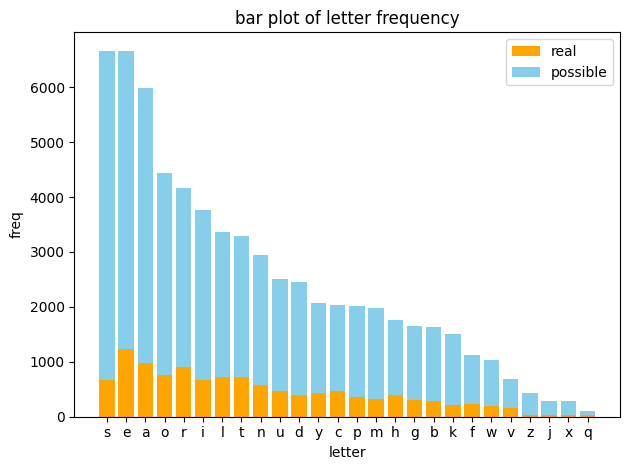

In [5]:
# all letters freq
all_letter_freq = set(pos_letter_freq.keys()) | set(real_letter_freq.keys())
total_freq = {
    letter: pos_letter_freq.get(letter, 0) + real_letter_freq.get(letter, 0)
    for letter in all_letter_freq
}

# sort
sorted_letters = sorted(total_freq.keys(), key=lambda l: total_freq[l], reverse=True)
real_val = [real_letter_freq.get(letter, 0) for letter in sorted_letters]
pos_val = [pos_letter_freq.get(letter, 0) for letter in sorted_letters]

# bar plot
plt.bar(sorted_letters, real_val, label='real', color='orange')
plt.bar(sorted_letters, pos_val, bottom=real_val, label='possible', color='skyblue')

# adjust
plt.xlabel('letter')
plt.ylabel('freq')
plt.title('bar plot of letter frequency')
plt.legend()
plt.tight_layout()
plt.show()


# find 1st word

In [6]:
# def func to score word
def score_word(word, freq_dict):
    return sum(freq_dict.get(letter, 0) for letter in set(word))

In [7]:
# test func
# run all words to score and find best word
scored_words = [(word, score_word(word, sorted_real_freq)) for word in real_words]
best_word = max(scored_words, key=lambda x: x[1])
print(f"best word : {best_word[0]},（score : {best_word[1]}）")


best word : alert,（score : 4559）


# find next word

next, we want to determine the next word to guess <br>
we will classify whether each letter is guessed correctly <br>
there are three possible cases: <br>
1. black: the letter does not exist in the target word <br>
2. yellow: the letter exists but is in the wrong position <br>
3. green: the letter exists and is in the correct position <br>

we should implement a function <br>
that takes as input (the current guessed word, and the color pattern, e.g., "bybbg") <br>
and returns the next word to guess <br>

-----

接著我們希望找出下一個單字 <br>
會區分出是否有猜對的 <br>
出現以下幾種情況 : <br>
1. black : 這個字不存在 <br>
2. yellow : 這個字存在，但位置錯誤 <br>
3. green : 這個字存在，並且位置正確 <br>

應該要製作一個函式 <br>
讓使用者輸入(目前猜的字，顏色的種類(bybbg類似這樣的表現方法)) <br>
最後返回下一個應該猜測的字 <br>

In [8]:
# basic setting
# init candidate words
candidate_words = [word for word in comb_words if len(word) == 5]
# get letter freq
letter_freq = Counter(chain.from_iterable(candidate_words))
# remember history
history = []  # [(guess1, feedback1), (guess2, feedback2), ...]


In [9]:
# def func to filter word
def filter_candidates(history, candidate_words):
    for guess, feedback in history:
        new_candidates = []

        for word in candidate_words:
            match = True
            # mark which letter is match
            used = [False]*5

            # first : solve green
            for i in range(5):
                if feedback[i] == 'g':
                    if word[i] != guess[i]:
                        match = False
                        break
                    # letter place is right
                    used[i] = True

            if not match:
                continue

            # second : solve yellow
            for i in range(5):
                if feedback[i] == 'y':
                    found = False
                    for j in range(5):
                        # place is another, but need to show in word
                        if not used[j] and word[j] == guess[i] and j != i:
                            used[j] = True
                            found = True
                            break
                    if not found:
                        match = False
                        break

            if not match:
                continue

            # third : solve black
            for i in range(5):
                if feedback[i] == 'b':
                    ch = guess[i]
                    allowed = sum(
                        1 for j in range(5) if feedback[j] in ['g', 'y'] and guess[j] == ch
                    )
                    actual = word.count(ch)
                    if actual > allowed:
                        match = False
                        break

            if match:
                new_candidates.append(word)
        # get new maybe word
        candidate_words = new_candidates

    return candidate_words


In [10]:
# find next best guess
def next_best_guess(candidate_words, letter_freq):
    if not candidate_words:
        return None
    # score all possible word and return best
    scored_words = [(word, score_word(word, letter_freq)) for word in candidate_words]
    return max(scored_words, key=lambda x: x[1])[0]


In [11]:
# update history to guess next word
def update_history_and_guess(prev_guess, feedback, history, candidate_words, letter_freq):
    # find the answer
    if feedback == "ggggg":
        print("congratulations, you find the answer🎉")
    # update history
    history.append((prev_guess, feedback))
    # update candidate
    filtered_words = filter_candidates(history, candidate_words)
    # get next best guess
    next_guess = next_best_guess(filtered_words, letter_freq)
    # if return none, use another file(default : `possible_words.txt`) to guess
    if next_guess is None:
        print("input file return no recommend, change into file--`possible_words.txt` to guess")
        filtered_words = filter_candidates(history, pos_words)
        next_guess = next_best_guess(filtered_words, letter_freq)

    return next_guess, filtered_words


# practical implementation 

In [12]:
# init
candidate_words = [word for word in real_words if len(word) == 5]
letter_freq = Counter(chain.from_iterable(candidate_words))
history = []

In [13]:
# first guess
first_guess = next_best_guess(candidate_words, letter_freq)
print(f"first recommend : {first_guess}")
# get feedback
first_feedback = input(f"enter feedback of '{first_guess}' (like : bybbg): ")


first recommend : alert


In [14]:
# update & second guess
second_guess, candidate_words = update_history_and_guess(
    first_guess, first_feedback, history, candidate_words, letter_freq
)
print(f"second recommend : {second_guess}")
# get feedback
second_feedback = input(f"enter feedback of '{second_guess}' (like : bybbg): ")


second recommend : piano


In [15]:
# update & third guess
third_guess, candidate_words = update_history_and_guess(
    second_guess, second_feedback, history, candidate_words, letter_freq
)
print(f"third recommend : {third_guess}")
# get feedback
third_feedback = input(f"enter feedback of '{third_guess}' (like : bybbg): ")


third recommend : saucy


In [16]:
# update & fourth guess
fourth_guess, candidate_words = update_history_and_guess(
    third_guess, third_feedback, history, candidate_words, letter_freq
)
print(f"fourth recommend : {fourth_guess}")
# get feedback
fourth_feedback = input(f"enter feedback of '{fourth_guess}' (like : bybbg): ")


fourth recommend : savvy


In [17]:
# update & fifth guess
fifth_guess, candidate_words = update_history_and_guess(
    fourth_guess, fourth_feedback, history, candidate_words, letter_freq
)
print(f"fifth recommend : {fifth_guess}")
# get feedback
fifth_feedback = input(f"enter feedback of '{fifth_guess}' (like : bybbg): ")


fifth recommend : sassy


In [18]:
# update & sixth guess
sixth_guess, candidate_words = update_history_and_guess(
    fifth_guess, fifth_feedback, history, candidate_words, letter_freq
)
print(f"sixth recommend : {sixth_guess}")
# get feedback
sixth_feedback = input(f"enter feedback of '{sixth_guess}' (like : bybbg): ")


input file return no recommend, change into file--`possible_words.txt` to guess
sixth recommend : sammy
